Group Members: Rosamelia Carioni, Elena Perego, Mischa Rauch.
Student IDs:

In [66]:
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from sklearn.model_selection import train_test_split
from pandas.api.types import CategoricalDtype
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_validate
from numpy import sqrt


# 1. Import data TODO: House density

In [2]:
crime_density = pd.read_csv('clean_data/crime.csv')
median_gross_earning = pd.read_csv('clean_data/median_gross_annual_earning.csv')
personal_well_being = pd.read_csv('clean_data/personal_well_being.csv')
population = pd.read_csv('clean_data/population_annual.csv')
waste = pd.read_csv('clean_data/waste.csv')
gas_energy_consumption = pd.read_csv('clean_data/energy_gas_consumption_annual.csv')
electricity_energy_consumption = pd.read_csv('clean_data/energy_electricity_consumption_annual.csv')
housing_density = pd.read_csv('clean_data/housing_density.csv')
# Both median and mean were stracted for experimentation purposes, however, for the final model the median will be considered.
median_house_price = pd.read_csv('clean_data/median_house_price.csv')

# 2. Clean and Structure the data

This step was done in the files 'reding_data_x.ipynb' where x={1,2,3}. In these files, the data was read, as extracted from London Data Store, and structured so that all of them had the same structure and features. The dataframes will be merged into one dataframe in step 5, after the outlier removal is done and the correlation with the house price is checked.

In [3]:
#df = crime_density.groupby(['Code', 'Year'])['Value'].sum().reset_index().pivot(index='Code', columns='Year', values='Value')

merge1 = pd.merge(crime_density,median_gross_earning, on = ['Area','Code','Year'])
merge2 = pd.merge(merge1, personal_well_being, on = ['Area','Code','Year'])
merge3 = pd.merge(merge2, population, on = ['Area','Code','Year'])
merge4 = pd.merge(merge3, waste, on = ['Area','Code','Year'])
merge5 = pd.merge(merge4, median_house_price, on = ['Area','Code','Year'])
data = pd.merge(merge5, housing_density, on = ['Area','Code','Year'])
#merge6 = pd.merge(merge5, gas_energy_consumption, on = ['Area','Code','Year'])
#data = pd.merge(merge6, electricity_energy_consumption, on = ['Area','Code','Year'])

# Fix the housing density
data['Housing_density'] = data['Housing_density'] / data['Population_estimates']
data

Code                  Area  Year  Number_of_crimes  \
0    E09000002  Barking and Dagenham  2011              1635   
1    E09000003                Barnet  2011              2243   
2    E09000004                Bexley  2011               982   
3    E09000005                 Brent  2011              2601   
4    E09000006               Bromley  2011              1797   
..         ...                   ...   ...               ...   
219  E09000029                Sutton  2017               953   
220  E09000030         Tower Hamlets  2017              2727   
221  E09000031        Waltham Forest  2017              1762   
222  E09000032            Wandsworth  2017              1936   
223  E09000033           Westminster  2017              4770   

     Median_annual_earning  Mean_life_satisfaction  Population_estimates  \
0                    28201                    7.05                187029   
1                    30237                    7.43                357538   
2                    28638                    7.42                232774   
3                    26772                    7.11                312245   
4                    28163                    7.50                310554   
..                     ...                     ...                   ...   
219                  27945                    7.91                203243   
220                  49369                    7.51                307964   
221                  28284                    7.73                275505   
222                  33137                    7.64                323257   
223                  42152                    7.57                244796   

     Waste_recycling_rates  Median_house_price  Housing_density  
0                30.000000            170000.0         0.380043  
1                33.600000            325000.0         0.389738  
2                53.500000            215000.0         0.408280  
3                36.800000            300000.0         0.358959  
4                49.900000            275000.0         0.434823  
..                     ...                 ...              ...  
219              50.048815            367000.0         0.404841  
220              26.449413            490000.0         0.383201  
221              32.481245            445000.0         0.371380  
222              22.085340            654000.0         0.445203  
223              18.846207           1025000.0         0.503954  

[224 rows x 10 columns]

In [34]:
corr = data.corr()
corr

/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_34912/2601176157.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = data.corr()


Year  Number_of_crimes  Median_annual_earning  \
Year                    1.000000         -0.027121               0.130202   
Number_of_crimes       -0.027121          1.000000               0.499517   
Median_annual_earning   0.130202          0.499517               1.000000   
Mean_life_satisfaction  0.553585         -0.257947              -0.026321   
Population_estimates    0.119302          0.385204              -0.046150   
Waste_recycling_rates  -0.039737         -0.485251              -0.391374   
Median_house_price      0.398161          0.275613               0.358302   
Housing_density        -0.091731          0.268462               0.312603   

                        Mean_life_satisfaction  Population_estimates  \
Year                                  0.553585              0.119302   
Number_of_crimes                     -0.257947              0.385204   
Median_annual_earning                -0.026321             -0.046150   
Mean_life_satisfaction                1.000000             -0.057358   
Population_estimates                 -0.057358              1.000000   
Waste_recycling_rates                 0.164894              0.015258   
Median_house_price                    0.317143             -0.324709   
Housing_density                      -0.010687             -0.446293   

                        Waste_recycling_rates  Median_house_price  \
Year                                -0.039737            0.398161   
Number_of_crimes                    -0.485251            0.275613   
Median_annual_earning               -0.391374            0.358302   
Mean_life_satisfaction               0.164894            0.317143   
Population_estimates                 0.015258           -0.324709   
Waste_recycling_rates                1.000000           -0.309681   
Median_house_price                  -0.309681            1.000000   
Housing_density                     -0.234212            0.724878   

                        Housing_density  
Year                          -0.091731  
Number_of_crimes               0.268462  
Median_annual_earning          0.312603  
Mean_life_satisfaction        -0.010687  
Population_estimates          -0.446293  
Waste_recycling_rates         -0.234212  
Median_house_price             0.724878  
Housing_density                1.000000

# 3. EDA: Outlier Removal (each does its own --> same as clinic but also make nicer)
# TODO: write that we do not remove outliers

## Helper functions

In [5]:
red = 'YlOrRd'
blue = 'BuPu'
green = 'YlGn'
def create_map(feature_name, color):
    # create a map centered on London
    london_map = folium.Map(location=[51.5074, -0.1278], zoom_start=10)

    # add choropleth layer to the map
    folium.Choropleth(
        geo_data='clean_data/london_boroughs.json',
        name='choropleth',
        data=data,
        columns=['Area', feature_name],
        key_on='feature.properties.name',
        fill_color= color,
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name=feature_name
    ).add_to(london_map)
    # add layer control to the map
    folium.LayerControl().add_to(london_map)
    # display the map
    return london_map

# Group data by year and calculate the mean of 'Mean_life_satisfaction'
def time_series_over_year(feature_name):
    mean_satisfaction = data.groupby('Year')[feature_name].mean()
    # Create a line plot of mean life satisfaction by year
    plt.plot(mean_satisfaction.index, mean_satisfaction.values)

    # Add labels and title to the plot
    plt.xlabel('Year')
    plt.ylabel(feature_name)

    # Show the plot
    plt.show()


def standardize_columns(data):
    # (value - mean) / std
    '''
    Input:
      data (data frame): contains only numeric columns
    Output:
      data frame, the same data, except each column is standardized
      to have 0-mean and unit variance
    '''
    mean_per_column = data.mean(axis=0, numeric_only = True) # This is not really needed, you can just do data.mean()
    std_per_column = data.std(axis=0, numeric_only = True)
    return (data - mean_per_column)/std_per_column


def plot_distribution_price_feature (feature_name, data):
    fig, axs = plt.subplots(nrows=2)

    sns.boxplot(
        x= feature_name,
        y='Mean_life_satisfaction',
        data=data.sort_values(feature_name),
        ax=axs[0]
    )

    sns.countplot(
        x= feature_name,
        data=data.sort_values(feature_name),
        ax=axs[1]
    )

    # Draw median price
    axs[0].axhline(
        y=data['Mean_life_satisfaction'].median(),
        color='red',
        linestyle='dotted'
    )

    # Label the bars with counts
    for patch in axs[1].patches:
        x = patch.get_bbox().get_points()[:, 0]
        y = patch.get_bbox().get_points()[1, 1]
        axs[1].annotate(f'{int(y)}', (x.mean(), y), ha='center', va='bottom')

    # Format x-axes
    axs[1].set_xticklabels(axs[1].xaxis.get_majorticklabels(), rotation=90)
    axs[0].xaxis.set_visible(False)

    # Narrow the gap between the plots
    plt.subplots_adjust(hspace=0.01)


def plot_linear_relationship_and_spread1(feature_name, data):
    sns.jointplot(
        x=feature_name,
        y='Mean_life_satisfaction',
        data=data,
        #    stat_func=None,
        kind="reg",
        ratio=4,
        space=0,
        scatter_kws={
            's': 3,
            'alpha': 0.25
        },
        line_kws={
            'color': 'black'
        }
    )


def plot_linear_relationship_and_spread(x_name, data, y_name):
    sns.jointplot(
        x=x_name,
        y=y_name,
        data=data,
        #    stat_func=None,
        kind="reg",
        ratio=4,
        space=0,
        scatter_kws={
            's': 3,
            'alpha': 0.25
        },
        line_kws={
            'color': 'black'
        }
    )

# 4. EDA: Visualizations 

## Housing Density

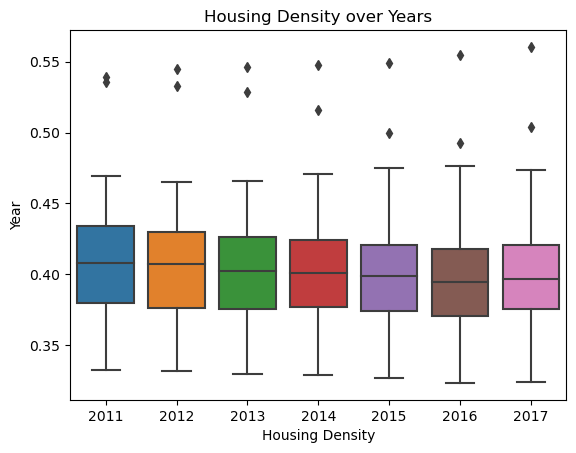

In [6]:
sns.boxplot(x = "Year",y="Housing_density",data = data)

# set the axis labels
plt.xlabel('Housing Density')
plt.ylabel('Year')

# set the title
plt.title('Housing Density over Years')

# display the plot
plt.show()

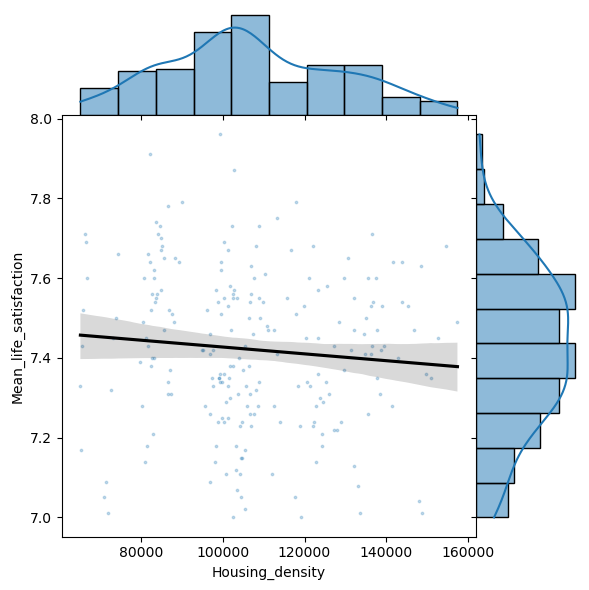

In [7]:
temp = data.copy()
temp['Housing_density'] = temp['Housing_density'] * temp['Population_estimates']
plot_linear_relationship_and_spread1('Housing_density',temp)


## Population

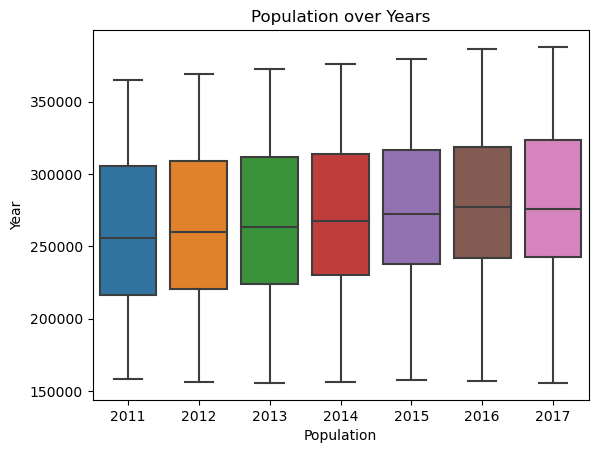

In [8]:
import seaborn as sns
sns.boxplot(x = "Year",y="Population_estimates",data = data)

# set the axis labels
plt.xlabel('Population')
plt.ylabel('Year')

# set the title
plt.title('Population over Years')


# display the plot
plt.show()

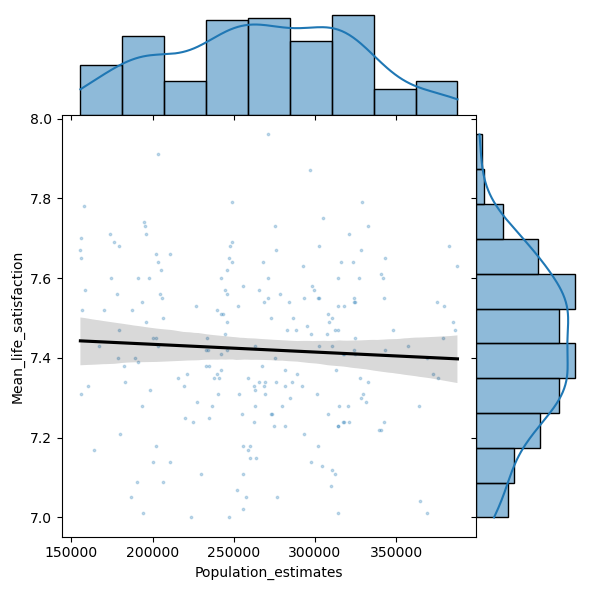

In [35]:
plot_linear_relationship_and_spread1('Population_estimates',data)

This should show correlations with happiness per feature. Meli: do happiness with year and neighbourhood.

## Personal Well-Being over the Years

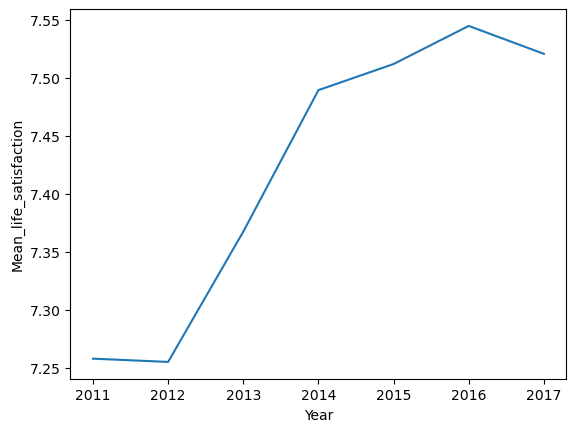

In [10]:
time_series_over_year('Mean_life_satisfaction')

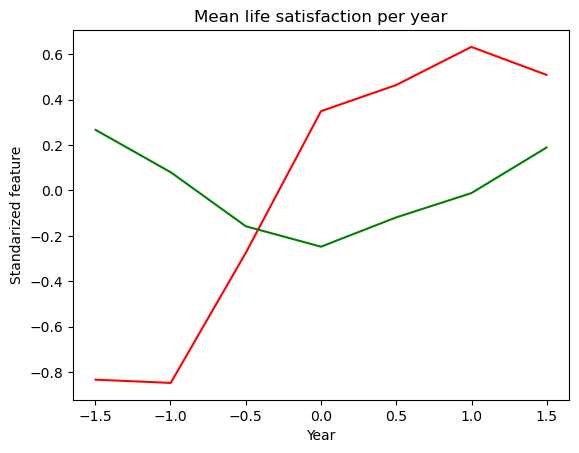

In [11]:
temp = data
temp = standardize_columns(temp)

# Group data by year and calculate the mean of 'Mean_life_satisfaction'
mean_satisfaction = temp.groupby('Year')['Mean_life_satisfaction'].mean()
mean_crimes = temp.groupby('Year')['Number_of_crimes'].mean()

year = range(2011,2017)
# Create a line plot of mean life satisfaction by year
plt.plot(mean_satisfaction.index, mean_satisfaction.values, color = 'r')
plt.plot(mean_crimes.index, mean_crimes.values, color = 'g')

# Add labels and title to the plot
plt.xlabel('Year')
plt.ylabel('Standarized feature')
plt.title('Mean life satisfaction per year')

# Show the plot
plt.show()

Text(0.5, 1.0, 'Mean life satisfaction per year')

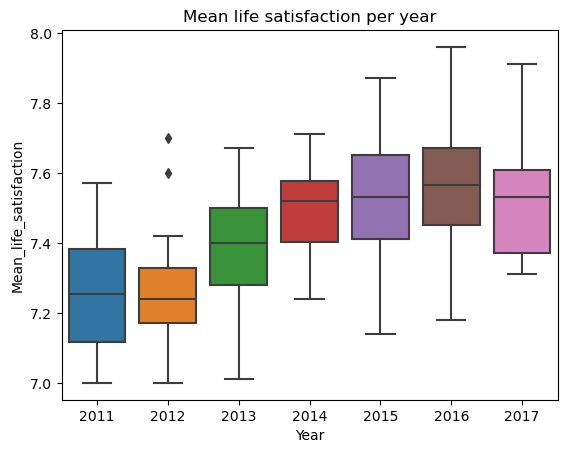

In [12]:
sns.boxplot(x="Year", y="Mean_life_satisfaction", data=data)
plt.title('Mean life satisfaction per year')

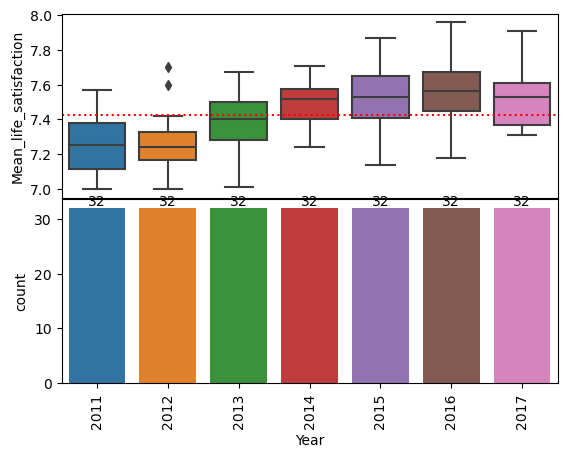

In [36]:
plot_distribution_price_feature('Year',data)

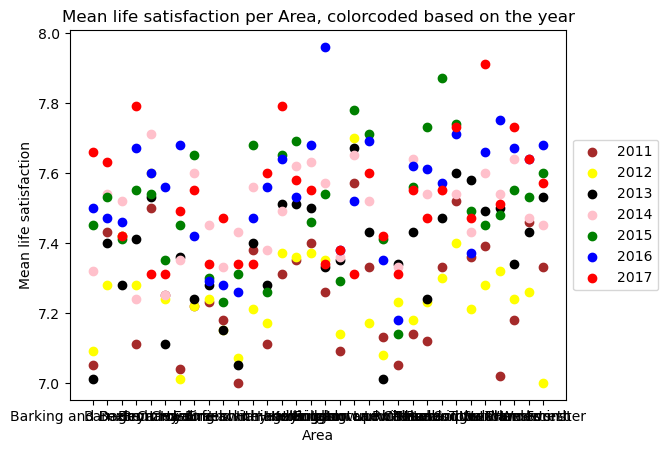

In [14]:
# Create a dictionary to map years to colors
color_dict = {2017: 'red', 2016: 'blue', 2015: 'green', 2014: 'pink', 2013:'black', 2012:'yellow', 2011:'brown'}

# Create the plot
fig, ax = plt.subplots()
for year, group in data.groupby('Year'):
    ax.scatter(group['Area'], group['Mean_life_satisfaction'], c=color_dict[year], label=str(year))

# Add labels and legend
ax.set_xlabel('Area')
ax.set_ylabel('Mean life satisfaction')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Show the plot
plt.title('Mean life satisfaction per Area, colorcoded based on the year')
plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

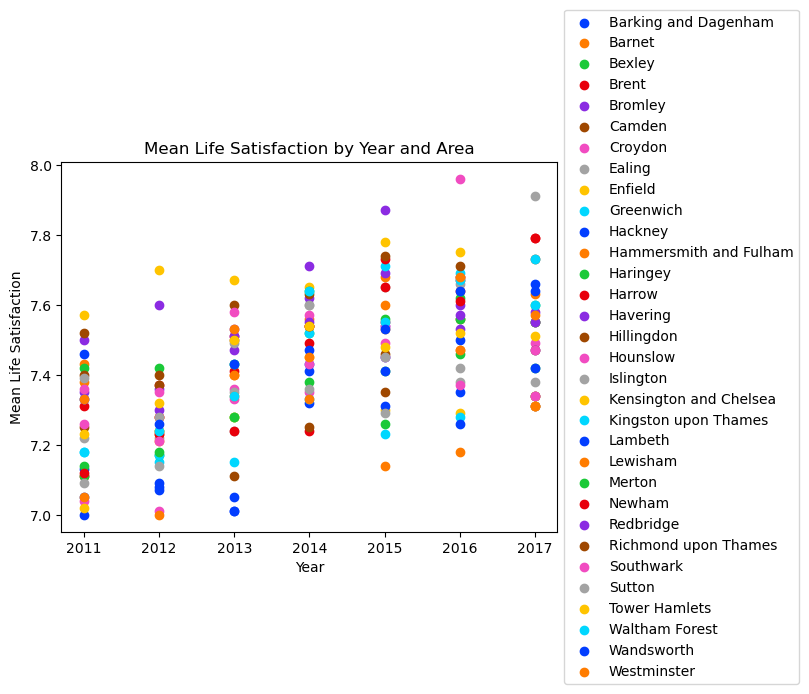

In [37]:
df = data

# Set the color palette based on the unique areas in the data
colors = sns.color_palette("bright", len(df['Area'].unique()))

# Create the plot
fig, ax = plt.subplots()
for i, area in enumerate(df['Area'].unique()):
    subset = df[df['Area'] == area]
    ax.scatter(subset['Year'], subset['Mean_life_satisfaction'], c=colors[i], label=area)

# Set the axis labels and title
ax.set_xlabel('Year')
ax.set_ylabel('Mean Life Satisfaction')
ax.set_title('Mean Life Satisfaction by Year and Area')

# Add the legend outside the plot
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Display the plot
plt.show()

## Neighbourhoods and Personal Well-Being

In [16]:
map_satisfaction = create_map('Mean_life_satisfaction', red)
map_satisfaction

## Average House Price and Personal Well-Being


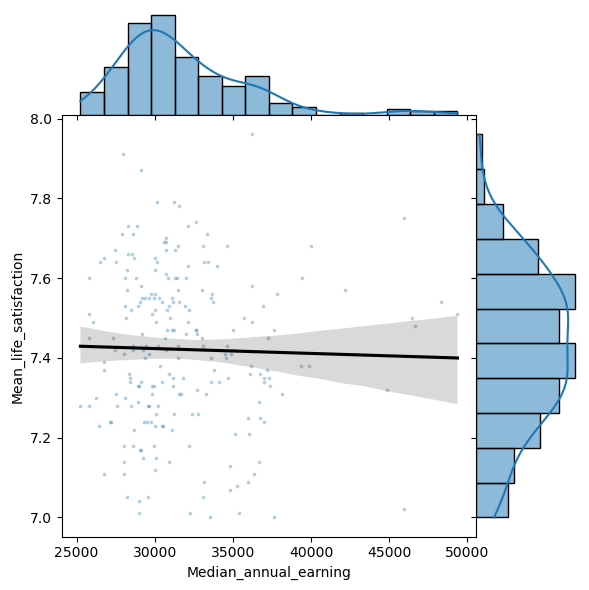

In [17]:
#plot_linear_relationship_and_spread('Median_house_price', data)
# Mischa comment I think we don't need this anymore do we?
plot_linear_relationship_and_spread1('Median_annual_earning', data)

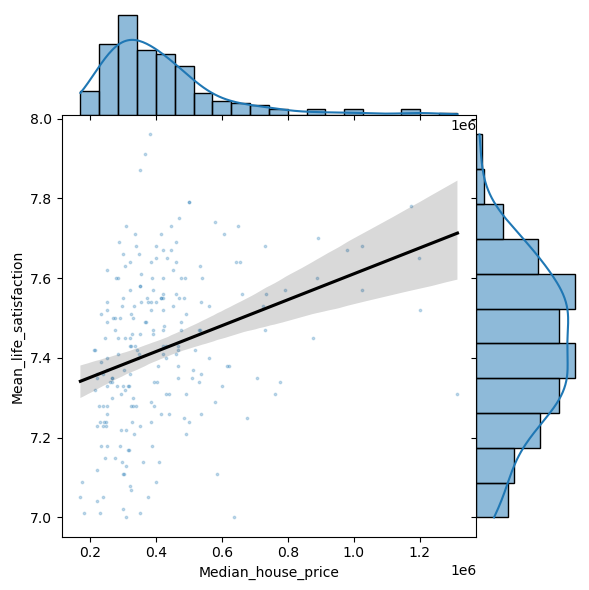

In [18]:
plot_linear_relationship_and_spread('Median_house_price', data, 'Mean_life_satisfaction')

In [20]:
map = create_map('Median_annual_earning', red)
map

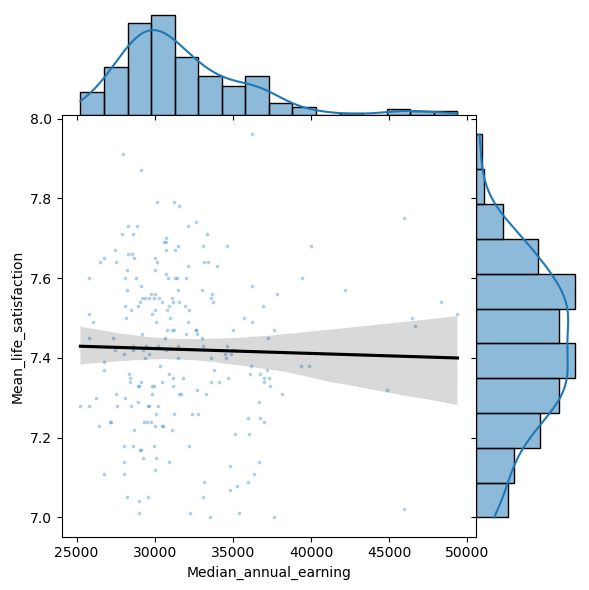

In [38]:
#plot_linear_relationship_and_spread('Median_house_price', merge5)
plot_linear_relationship_and_spread1('Median_annual_earning', data)


## Average Income and Personal Well-Being


### Make plot --> RQ 1 --> "How does location of neighborhoods affect personal well-being in London?"  (ELENA)

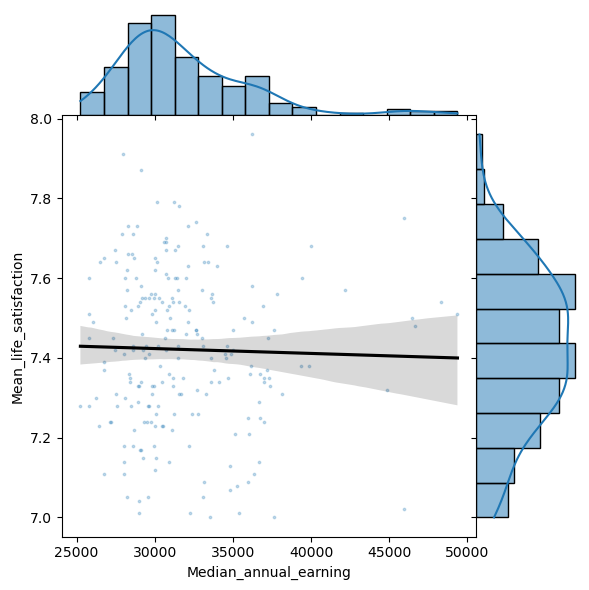

In [22]:
plot_linear_relationship_and_spread('Median_annual_earning', data, 'Mean_life_satisfaction')

In [23]:
# create a map centered on London
london_map = folium.Map(location=[51.5074, -0.1278], zoom_start=10)

# add choropleth layer to the map
folium.Choropleth(
    geo_data='clean_data/london_boroughs.json',
    name='choropleth',
    data=median_house_price,
    columns=['Area', '2000'],
    key_on='feature.properties.name',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Average House Price (£)'
).add_to(london_map)

# add layer control to the map
folium.LayerControl().add_to(london_map)

# display the map
london_map

KeyError: '2000'

## Crime rates and Personal Well-Being

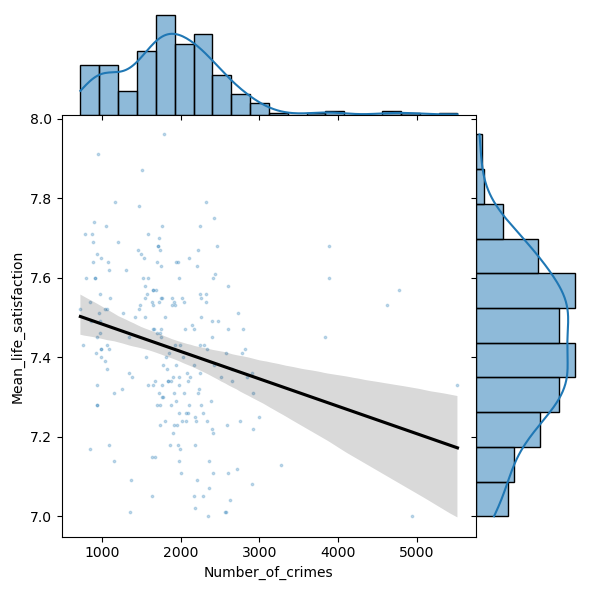

In [25]:
plot_linear_relationship_and_spread1('Number_of_crimes', data)

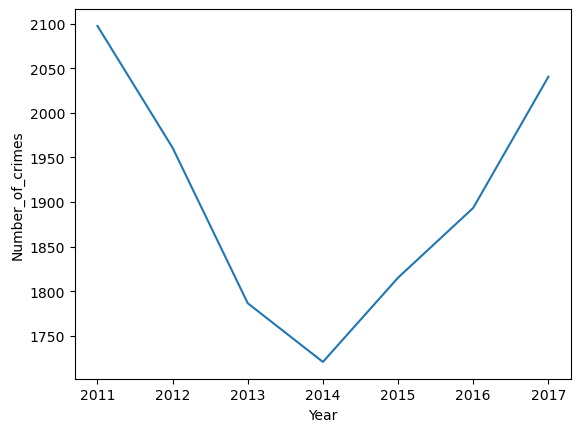

In [26]:
time_series_over_year('Number_of_crimes')

In [27]:
map_crime = create_map('Number_of_crimes', blue)
map_crime

## Waste

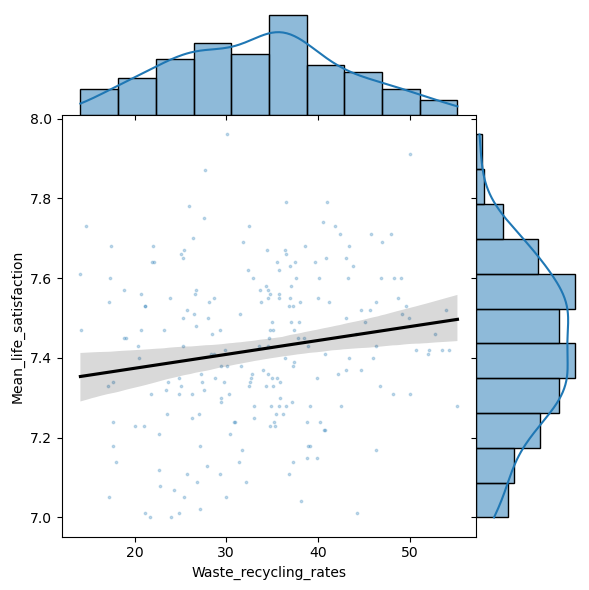

In [31]:
plot_linear_relationship_and_spread1('Waste_recycling_rates', data)

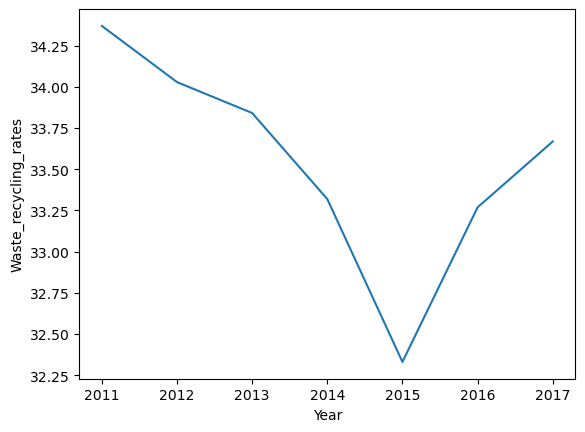

In [32]:
time_series_over_year('Waste_recycling_rates')

In [33]:
map_waste = create_map('Waste_recycling_rates', green)
map_waste

### Compare all variables with nice plots to house price --> RQ 2  (Meli: hers + crime, Mischa: his + house density, Ele: waste)

# 5. Models for Personal-Wellbeing Prediction

# 5.0 Create training set (ALL: based on results from before, create a df, verifying the correlation of variables) S

In [57]:
def ohe_code(data):
    """
    One-hot-encodes a feature.  New columns are of the form zone_AREA
    """
    cats = [
        'E09000002',
        'E09000003',
        'E09000004',
        'E09000005',
        'E09000006',
        'E09000007',
        'E09000008',
        'E09000009',
        'E09000010',
        'E09000011',
        'E09000012',
        'E09000013',
        'E09000014',
        'E09000015',
        'E09000016',
        'E09000017',
        'E09000018',
        'E09000019',
        'E09000020',
        'E09000021',
        'E09000022',
        'E09000023',
        'E09000024',
        'E09000025',
        'E09000026',
        'E09000027',
        'E09000028',
        'E09000029',
        'E09000030',
        'E09000031',
        'E09000032',
        'E09000033'
    ]

    cat_type = CategoricalDtype(categories=cats)

    data['Code'] = data['Code'].astype(cat_type)
    data = pd.get_dummies(data,
                          prefix='code',
                          columns=['Code'],
                          drop_first=True)

    return data

In [73]:
train_set, test_set = train_test_split(data, test_size=0.20, random_state=123)
X_train = train_set.drop(['Mean_life_satisfaction','Area'],axis=1)
y_train = train_set['Mean_life_satisfaction']
X_test = test_set.drop(['Mean_life_satisfaction','Area'],axis=1)
y_test = test_set['Mean_life_satisfaction']

X_train = ohe_code(X_train)
X_test = ohe_code(X_test)

## 5.1 Linear Regression (elena)

## 5.2 Polynomial Regression (Mischa)

In [77]:
poly_lin_mod = Pipeline([
        ("poly_features", PolynomialFeatures(degree=2)),
        ("linear", LinearRegression())
    ])

start = datetime.now()

poly_lin_mod.fit(X_train, y_train)
score = cross_validate(poly_lin_mod, X_train, y_train, cv=3)

predict = poly_lin_mod.predict(X_test)
end = datetime.now()
print("Score: ",poly_lin_mod.score(X_train,y_train))
print("Mean Square Error: ", mean_squared_error(y_test, predict))
print("Root Mean Squared Error ", sqrt(mean_squared_error(y_test,predict)))
print("Mean Absolute Error ", mean_absolute_error(y_test,predict))
print("Mean Absolute Percentage Error ", mean_absolute_percentage_error(y_test,predict))
print("---------------------")
print("Elapsed", (end - start).total_seconds(), "seconds")

Score:  0.9999999407202332
Mean Square Error:  2.9351141433719596
Root Mean Squared Error  1.7132174828001143
Mean Absolute Error  0.8889752912506341
Mean Absolute Percentage Error  0.11954039037695895
---------------------
Elapsed 0.049624 seconds


## 5.3 Random Forest (Meli)

## 5.4 Neural Network (Mischa)

# 6. Ethical Implications (Elena, Meli)

# 7. Conclusion (ALL)

In [ ]:
median_house_price = np.